# HPGe Simulation

Importing libraries and initialising global constants

In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
from scipy.optimize import curve_fit
import glob
import os
import itertools

In [2]:
#taken from europium gamma decay spectrum, all decay channels with an intensity >0.01%
europium_energy_peaks_ev = [121781.7, 125690, 148010, 212568, 244697.4, 251633, 271131, 275449, 285980, 295938.7, 315174, 324830, 329425, 340400,
                           344278.5, 351660, 367789.1, 411116.5, 416048, 440860, 443965, 482310, 488679.2, 493508, 503474, 511000, 520227, 523130,
                           526881, 534245, 556560, 562930, 563990, 566442, 586265, 656489, 664780, 671155, 674675, 674677, 678623, 686610, 688670,
                           712843, 719349, 727990, 764900, 768944, 778904.5, 794810, 810451, 839360, 841574, 867380, 896580, 901181, 906010, 919337,
                           926317, 930580, 958630, 963390, 964079, 974090, 990190, 1005272, 1084000, 1085337, 1089737, 1109174, 1112076, 1170930,
                           1206110, 1212948, 1249938, 1261343, 1292778, 1299142, 1348100, 1363770, 1408013, 1457643, 1528103]

europium_decay_probabilities_percent = [28.41, 0.019, 0.035, 0.0196, 7.55, 0.0671, 0.078, 0.0323, 0.01, 0.442, 0.0496, 0.0738, 0.129, 0.031, 26.59,
                                        0.014, 0.862, 2.238, 0.109, 0.0133, 0.32, 2.8, 0.0279, 0.4139, 0.0278, 0.1533, 0.054, 0.0536, 0.0113, 0.0129, 
                                        0.0368, 0.0177, 0.038, 0.457, 0.131, 0.462,  0.1437, 0.01, 0.0194, 0.17, 0.0171, 0.47, 0.02, 0.841, 0.0961,
                                        0.268, 0.0106, 0.19, 0.088, 12.97, 0.0263, 0.317, 0.016, 4.243, 0.0669, 0.084, 0.016, 0.429, 0.273, 0.0729,
                                        0.021, 0.1341, 14.5, 0.0138, 0.0315, 0.665, 0.244, 10.13, 1.73, 0.186, 13.41, 0.0365, 0.0135, 1.416, 0.186,
                                        0.0336, 0.104, 1.633, 0.0175, 0.0256, 20.85, 0.498, 0.281]


cobalt_energy_peaks_ev = [347140, 826100, 1173222.8, 1332492, 2158570, 2505692]
cobalt_decay_probabilities_percent = [0.0075, 0.0076, 99.85, 99.9826, 0.0012, 0.000002]

americium_energy_peaks_ev = [26344.6, 32183, 33196.3, 43420, 55560, 59540.9, 98970, 102980]
americium_decay_probabilities_percent = [2.31, 0.0174, 0.1215, 0.0669, 0.0181, 35.92, 0.0203, 0.0195]

def normalise_probabilities(prob_table):
    prob_total = 0

    for prob in prob_table:
        prob_total += prob

    prob_table = np.array(prob_table)
    normalised_prob_table = prob_table / prob_total
    normalised_prob_table = normalised_prob_table.tolist()

    return normalised_prob_table

normalised_europium_decay_probabilities = normalise_probabilities(europium_decay_probabilities_percent)
normalised_cobalt_decay_probabilities = normalise_probabilities(cobalt_decay_probabilities_percent)
normalised_americium_decay_probabilities = normalise_probabilities(americium_decay_probabilities_percent)

decay_energies = [europium_energy_peaks_ev, cobalt_energy_peaks_ev, americium_energy_peaks_ev]
decay_probabilities = [normalised_europium_decay_probabilities, normalised_cobalt_decay_probabilities, normalised_americium_decay_probabilities]

## Defining the materials

In [3]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

beryllium_mat = openmc.Material()
beryllium_mat.add_element('Be', 1, percent_type = 'ao')
beryllium_mat.set_density('g/cm3', 1.848)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

vacuum_mat = openmc.Material()#setting a vacuum material as air with a near-zero density
vacuum_mat.add_element('C', 0.00015, percent_type = 'ao')
vacuum_mat.add_element('N', 0.784429, percent_type = 'ao')
vacuum_mat.add_element('O', 0.210750, percent_type = 'ao')
vacuum_mat.add_element('Ar', 0.004671, percent_type = 'ao')
vacuum_mat.set_density('g/cm3', 0.001)


materials = openmc.Materials([aluminium_mat, beryllium_mat, copper_mat, germanium_mat, lead_mat, mylar_mat, vacuum_mat])
materials.export_to_xml()

## Defining the geometries

In [4]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z', boundary_type = 'vacuum')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -23], 23, 10, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -23], 22.9, 9.9, axis = 'z')

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11], 10.494, 9, axis = 'z')
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.7], 10.2, 8.92, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.506], 0.003, 9, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.503], 0.003, 9, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -5.543], 5.03, 7.07, axis = 'z')
germanium_crystal.id = 1

#germanium_crystal_top = openmc.ZPlane(z0=-5.543 + 7.07, boundary_type='transmission')

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -46), 43.704, 0.44, axis = 'z')
interior_hole_sphere = openmc.Sphere(0, 0, -2.356, 0.44)

Rounded Hole Region: ((-28 29 -30) | -31)
Lead Shield Region: (-1 2 -3 (4 | -5 | 6))
Outer Cylinder Region: (-7 8 -9 (10 | -11 | 12) ~((-28 29 -30) | -31))
Aluminium Case Region: (-13 14 -15 (16 | -17 | 18) ~((-28 29 -30) | -31))
Aluminium Layer Region: (-19 20 -21)
Mylar Layer Region: (-22 23 -24)
Germanium Crystal Region: (-25 26 -27 ~((-28 29 -30) | -31))
Vacuum Region: (-4 5 -6 ~(-7 8 -9 (10 | -11 | 12) ~((-28 29 -30) | -31)) ~(-13 14 -15 (16 | -17 | 18) ~((-28 29 -30) | -31)) ~(-19 20 -21) ~(-22 23 -24) ~(-25 26 -27 ~((-28 29 -30) | -31)))


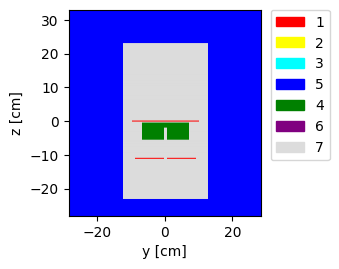

In [5]:
colour_assignment = {aluminium_mat: 'red', beryllium_mat: 'yellow', copper_mat: 'cyan', lead_mat: 'blue', germanium_mat: 'green', mylar_mat: 'purple',
                    vacuum_mat: 'gainsboro'}

rounded_hole_region = -interior_hole_cylinder | -interior_hole_sphere
print(f"Rounded Hole Region: {rounded_hole_region}")

lead_shield_region = -lead_shield_out & +lead_shield_in
print(f"Lead Shield Region: {lead_shield_region}")
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & ~rounded_hole_region
print(f"Outer Cylinder Region: {outer_cylinder_region}")
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & ~rounded_hole_region
print(f"Aluminium Case Region: {aluminium_case_region}")
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
print(f"Aluminium Layer Region: {aluminium_layer_region}")
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
print(f"Mylar Layer Region: {mylar_layer_region}")
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & ~rounded_hole_region
print(f"Germanium Crystal Region: {germanium_crystal_region}")
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

vacuum_region = -lead_shield_in & ~outer_cylinder_region & ~aluminium_case_region & ~aluminium_layer_region & ~mylar_layer_region & ~germanium_crystal_region
print(f"Vacuum Region: {vacuum_region}")
vacuum_cell = openmc.Cell(region=vacuum_region)
vacuum_cell.fill = vacuum_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, 
                            mylar_layer_cell, vacuum_cell])

plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment, legend = True)

geometry.export_to_xml()


## Creating settings

In [6]:
settings = []

for i in range(len(decay_energies)):
    setting = openmc.Settings()
    setting.batches = 100
    setting.particles = 10000
    setting.run_mode = 'fixed source'
    
    source = openmc.IndependentSource()
    source.space = openmc.stats.Point((0,0,0.5))
    source.particle = 'photon'
    source.angle = openmc.stats.Isotropic()
    energy_distribution = openmc.stats.Discrete(decay_energies[i], decay_probabilities[i])
    source.energy = energy_distribution
    setting.source = source

    settings.append(setting)

In [7]:
energy_bins = np.linspace(americium_energy_peaks_ev[0]-10000, cobalt_energy_peaks_ev[-1]+10000, num = 10000)
energy_filter = openmc.EnergyFilter(energy_bins)
mesh = openmc.RegularMesh()
mesh.dimension = [10, 10, 10]
mesh.lower_left = [-5.03, -5.03, -5.543]
mesh.upper_right = [5.03, 5.03, -0.5]

cell_filter = openmc.CellFilter(germanium_crystal_cell)
particle_filter = openmc.ParticleFilter('photon')

tally = openmc.Tally(name = 'pulse_height')
tally.filters = [cell_filter, energy_filter]
tally.scores = ['pulse-height']

tally2 = openmc.Tally(name = 'photon_number')
tally2.filters = [cell_filter, energy_filter, particle_filter]
tally2.scores = ['flux']

tallies = openmc.Tallies()
tallies.append(tally)
tallies.append(tally2)
tallies.export_to_xml()

## Running initial HPGe spectra simulation

In [8]:
%%time

def remove_files(pattern):
    for filename in glob.glob(pattern):
        os.remove(filename)
    
def run_simulation(setting):
    model = openmc.model.Model(geometry, materials, setting, tallies)
    remove_files('*.h5')

    results_filename = model.run(mpi_args = ['mpiexec', '-n', '4'], threads = 4)
    results = openmc.StatePoint(results_filename)
    pulse = results.get_tally(name = 'pulse_height')
    pulse_mean = pulse.mean.ravel()
    events = results.get_tally(name = 'photon_number')
    events_mean = events.mean.ravel()

    return pulse_mean, events_mean

def run_multiple_simulations():
    results_table = []
    events_table = []

    for setting in settings:
        pulse, events = run_simulation(setting)
        pulse.tolist()
        events.tolist()
        results_table.append(pulse)
        events_table.append(events)

    return results_table, events_table


results, events = run_multiple_simulations()

          favor of the model.xml file.
                                  %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%

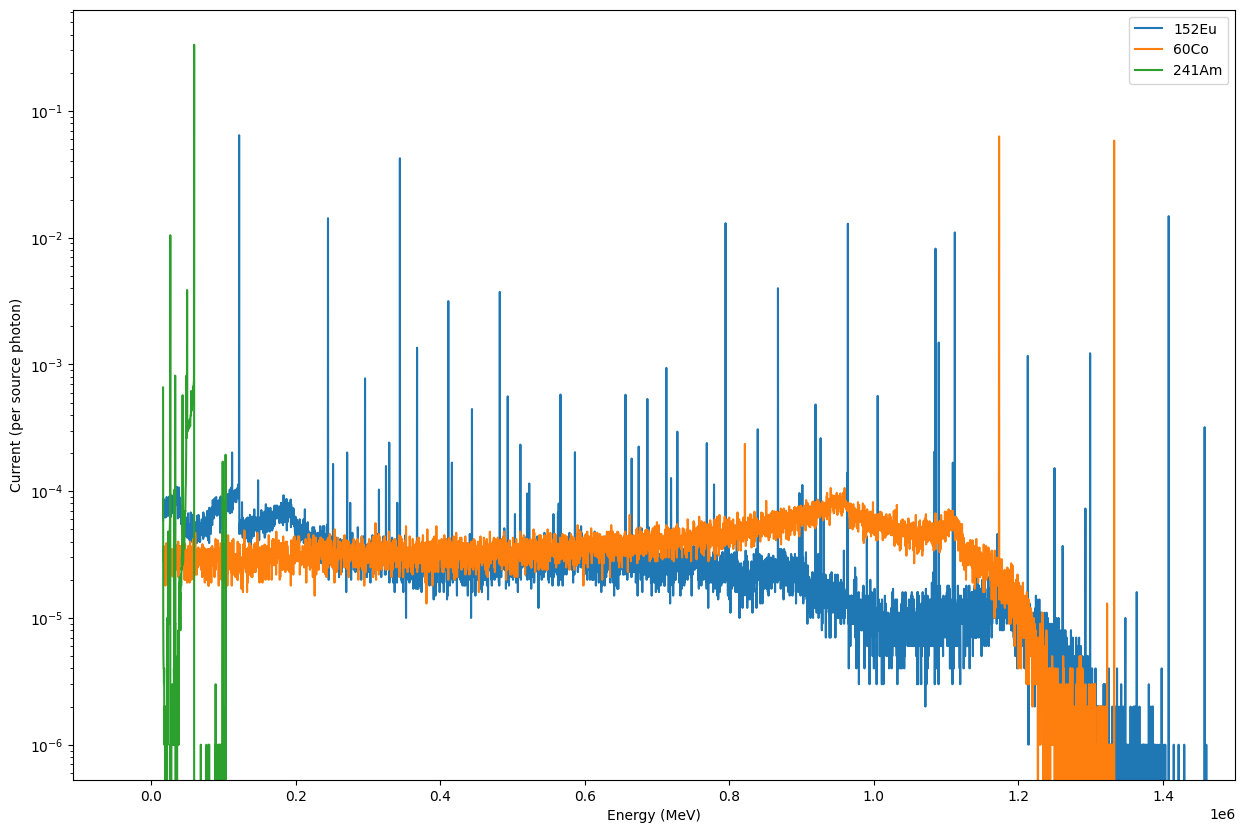

3


In [9]:
#print(results[0].tolist())
fig = plt.figure(figsize = [15, 10])
labels = ['152Eu', '60Co', '241Am']

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], results[i], label = labels[i])

plt.yscale('log')
plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.legend()
plt.show()
print(len(results))

## Applying Gaussian broadening and removing the background spectrum

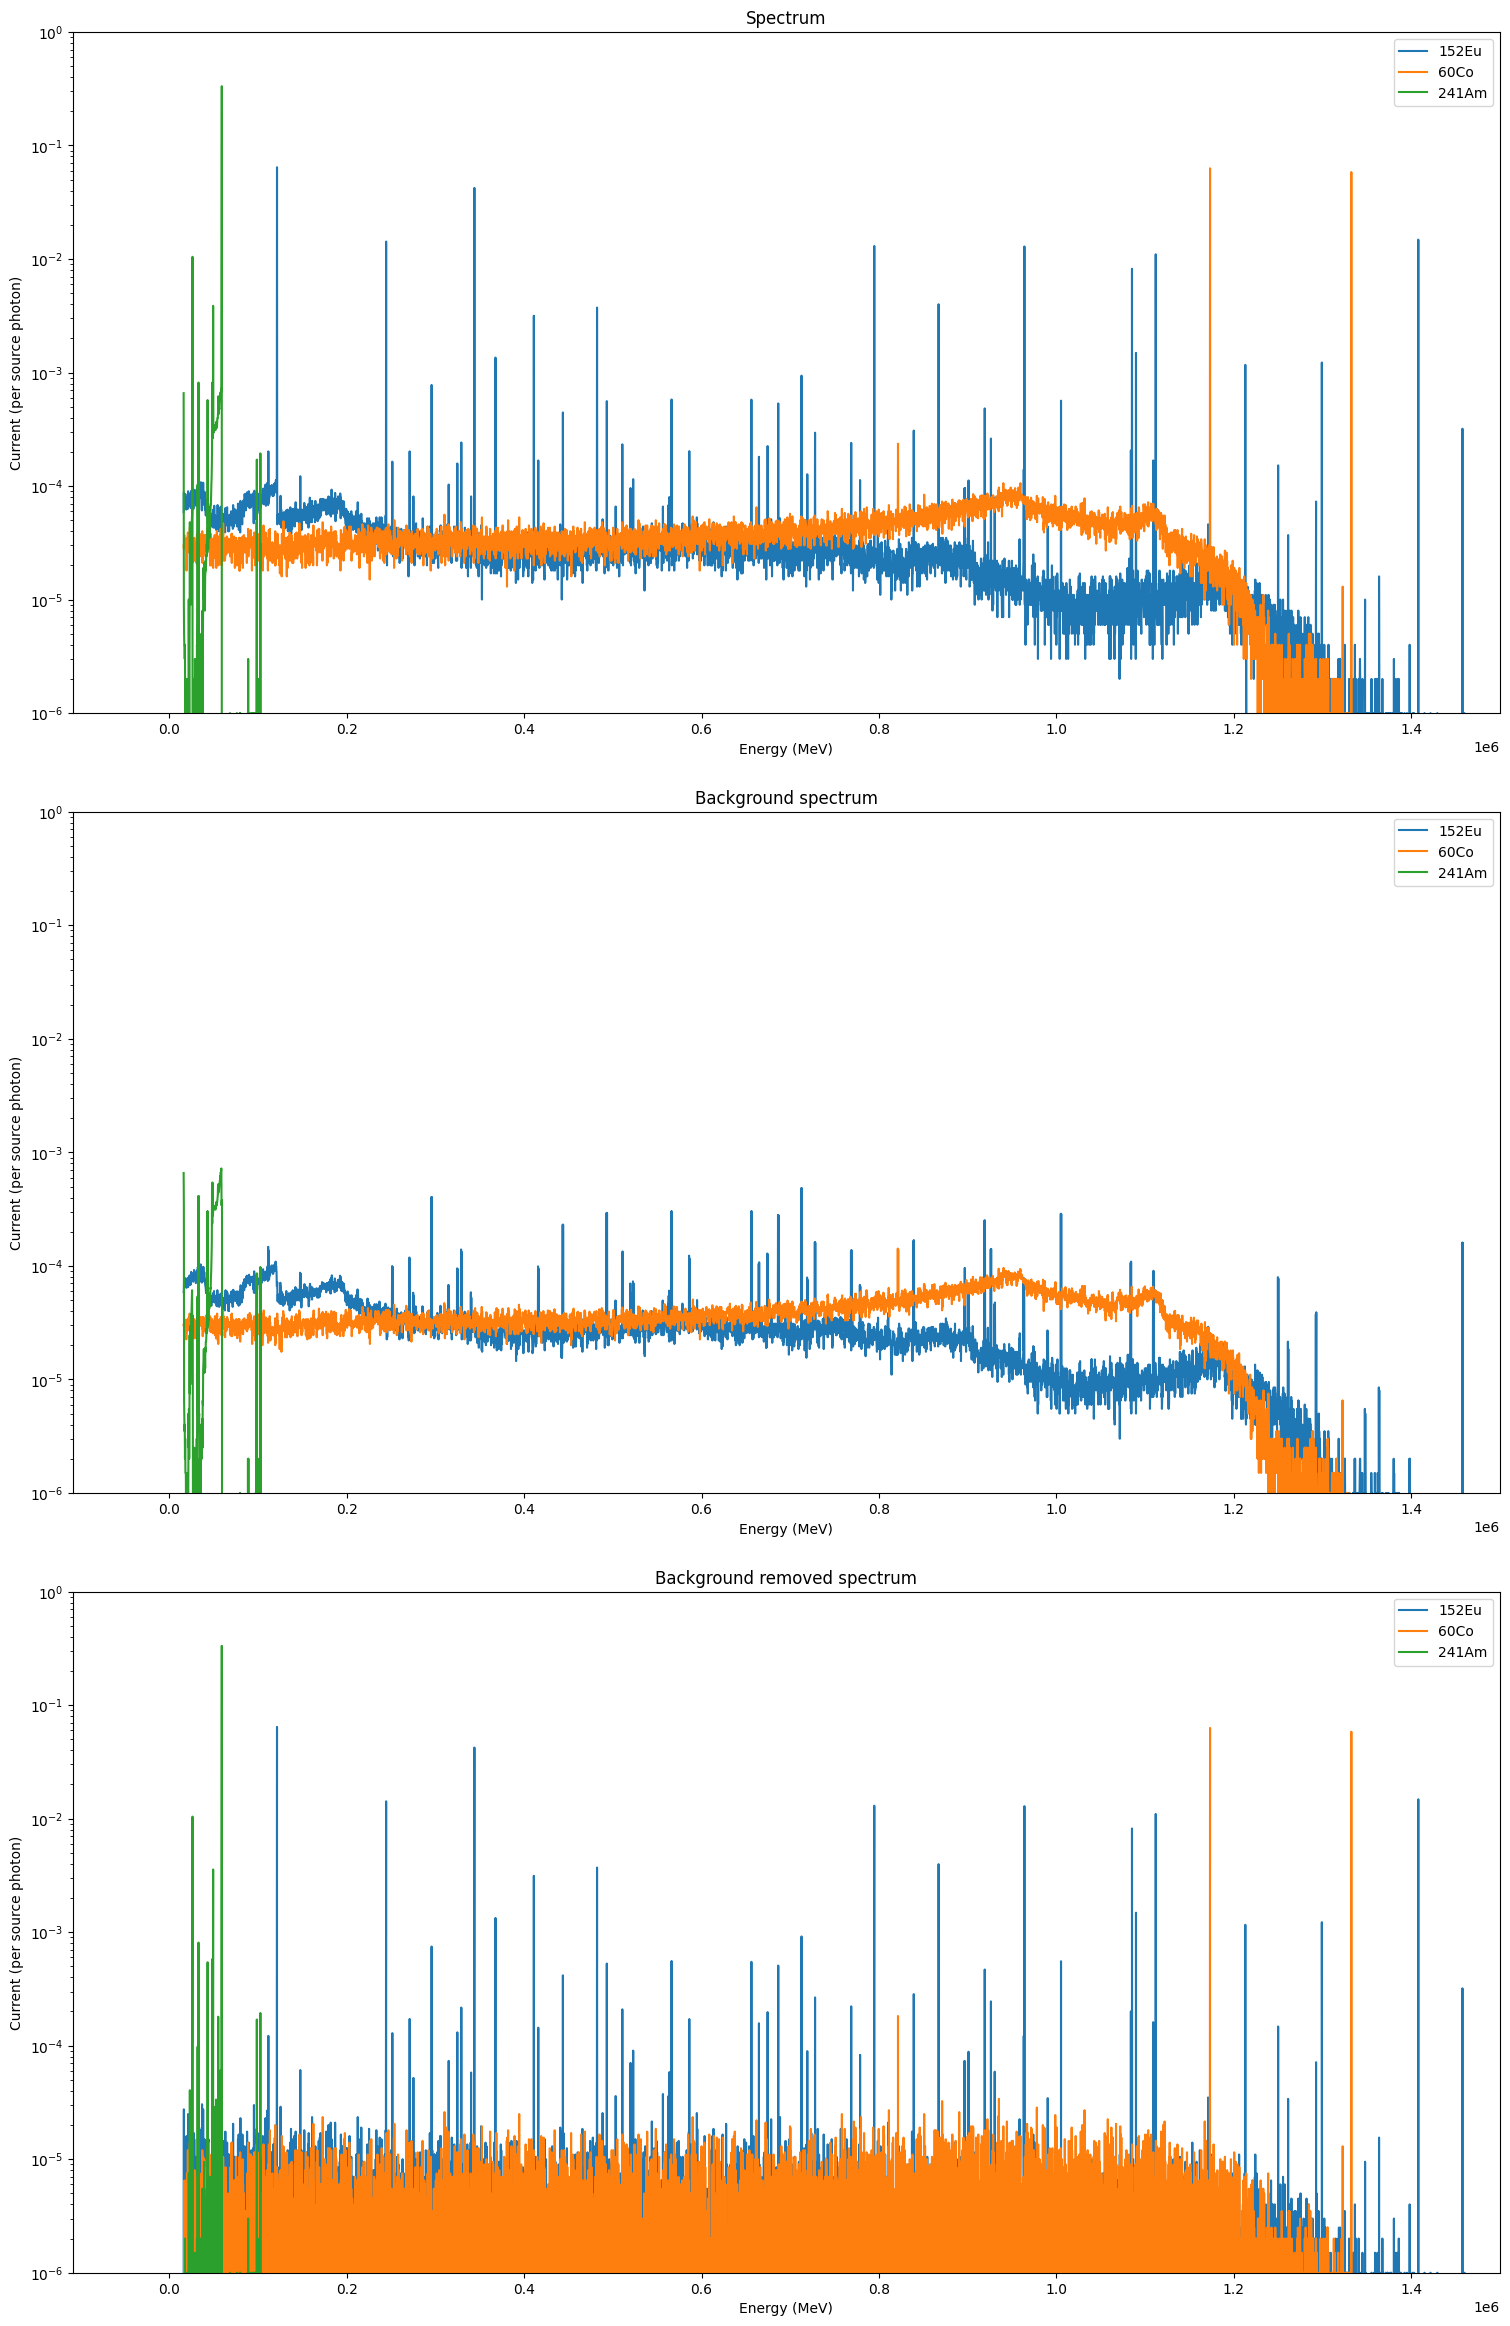

In [10]:
fig, ax = plt.subplots(3,1)
fig.set_figheight(23)
fig.set_figwidth(15)
broadened_data = []
backgrounds = []
background_removed_spectra = []

event_backgrounds = []
background_removed_events = []
fig.tight_layout(h_pad = 5)

def apply_gaussian_broadening(energy_bins, spectrum, fwhm):
    std = fwhm / (2 * np.sqrt(2 * np.log(2)))

    broadened_spectrum = np.zeros_like(spectrum)

    for i in range(len(spectrum)):
        gaussian = np.exp(-0.5 * ((energy_bins - energy_bins[i]) / std) ** 2)
        gaussian /= gaussian.sum()
        broadened_spectrum += spectrum[i] * gaussian

    return broadened_spectrum


def find_background(spectrum):
    background = []

    for i in range(len(spectrum)):
        background_counter = 1
        
        while True:
            left_index = i - background_counter
            right_index = i + background_counter
            
            if left_index < 0 or right_index >= len(spectrum):
                background.append(spectrum[i])
                break
            
            if spectrum[right_index] < 1E-3 and spectrum[left_index] < 1E-3:
                background.append((spectrum[left_index] + spectrum[right_index]) / 2)
                break
            
            background_counter += 1
    
    return background

def find_background_removed_spectrum(spectrum, background):
    background_removed_spectrum = []

    for i in range(len(spectrum)):
        background_removed_data = spectrum[i] - background[i]
    
        if background_removed_data < 0:
            background_removed_spectrum.append(0)

        else:
            background_removed_spectrum.append(background_removed_data)

    return background_removed_spectrum


for i in range(len(labels)):
    broadened_graph = apply_gaussian_broadening(energy_bins[:-1], results[i], 0.00195)
    broadened_data.append(broadened_graph)
    ax[0].plot(energy_bins[:-1], broadened_graph, label = labels[i])

for i in range(len(labels)):
    background_spectra = find_background(broadened_data[i])
    events_background_spectra = find_background(events[i])
    backgrounds.append(background_spectra)
    event_backgrounds.append(events_background_spectra)
    ax[1].plot(energy_bins[:-1], background_spectra, label = labels[i])


for i in range(len(labels)):
    background_removed_spectrum = find_background_removed_spectrum(broadened_data[i], backgrounds[i])
    background_removed_event_spectrum = find_background_removed_spectrum(events[i], event_backgrounds[i])
    background_removed_spectra.append(background_removed_spectrum)
    background_removed_events.append(background_removed_event_spectrum)
    ax[2].plot(energy_bins[:-1], background_removed_spectrum, label = labels[i])

ax[0].set_yscale('log')
ax[0].set_ylim((1e-6, 1))
ax[0].set_xlim(right = 1.5E6)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Current (per source photon)')
ax[0].set_title('Spectrum')
ax[0].legend()

ax[1].set_yscale('log')
ax[1].set_ylim((1e-6, 1))
ax[1].set_xlim(right = 1.5E6)
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Current (per source photon)')
ax[1].set_title('Background spectrum')
ax[1].legend()

ax[2].set_yscale('log')
ax[2].set_ylim((1e-6, 1))
ax[2].set_xlim(right = 1.5E6)
ax[2].set_xlabel('Energy (MeV)')
ax[2].set_ylabel('Current (per source photon)')
ax[2].set_title('Background removed spectrum')
ax[2].legend()

plt.show()

## Finding the peaks in the data

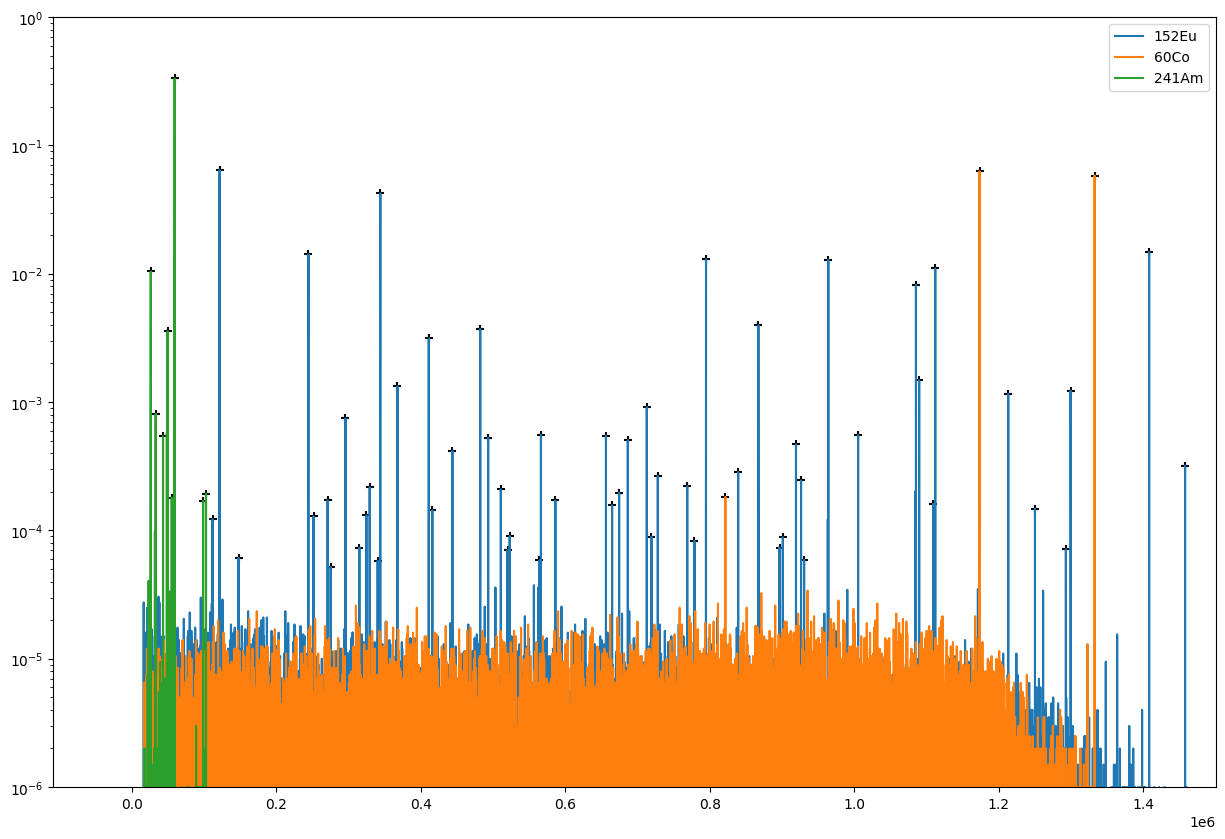

In [11]:
fig = plt.figure(figsize=[15, 10])
peaks_list = []
current_list = []

def find_energy_peaks(energy_bins, spectrum):
    peak_locations = list(scipy.signal.find_peaks(spectrum, distance = 10, prominence = 0.00005, width = 0.01))[0]
    peaks = []
    current = []
    
    for location in peak_locations:
        peaks.append(float(energy_bins[location]))
        current.append(float(spectrum[location]))

    peaks_list.append(peaks)
    current_list.append(current)
    
    return peaks, current

for i in range(len(labels)):
    #get background removed spectra specifically at the points where the peaks are! use the 1d intersection thing

    peaks, current = find_energy_peaks(energy_bins[:-1], background_removed_spectra[i])
    plt.plot(energy_bins[:-1], background_removed_spectra[i], label = labels[i])
    plt.scatter(peaks, current, marker = '+', color = 'k')

plt.yscale('log')
plt.ylim((1e-6, 1))
plt.xlim(right = 1.5E6)
plt.legend()
plt.show()

## Intrinsic efficiency simulation

involves pointing a beam directly at the germanium detector and recording the number of photons picked up for each energy

In [12]:
beam_tallies_list = []
photon_beam_energies = np.linspace(10000, 3000000, 100000)
photon_beam_probabilities = np.full(len(photon_beam_energies), 1/len(photon_beam_energies))

beam_setting = openmc.Settings()
beam_setting.batches = 100
beam_setting.particles = 10000
beam_setting.run_mode = 'fixed source'

beam_source = openmc.IndependentSource()
beam_source.space = openmc.stats.Point((0,0,0.5))
beam_source.particle = 'photon'
beam_source.angle = openmc.stats.Monodirectional((0,0,-1))
beam_energy_distribution = openmc.stats.Discrete(photon_beam_energies, photon_beam_probabilities)
beam_source.energy = beam_energy_distribution
beam_setting.source = beam_source
beam_setting.photon_transport = True

beam_cell_filter = openmc.CellFilter(germanium_crystal_cell)
beam_particle_filter = openmc.ParticleFilter('photon')
beam_energy_filter = openmc.EnergyFilter(np.linspace(americium_energy_peaks_ev[0]-10000, cobalt_energy_peaks_ev[-1]+10000, num = 100))
beam_tally = openmc.Tally(name = 'beam_pulse_height')
beam_tally.filters = [beam_cell_filter, beam_energy_filter, beam_particle_filter]
beam_tally.scores = ['current']
beam_tallies = openmc.Tallies()
beam_tallies.append(beam_tally)
beam_tallies.export_to_xml()
beam_tallies_list.append(beam_tallies)

In [13]:
def run_beam_simulation(tally):
    model2 = openmc.model.Model(geometry, materials, beam_setting, tally)
    remove_files('*.h5')

    results_filename = model2.run(mpi_args = ['mpiexec', '-n', '4'], threads = 4)
    results = openmc.StatePoint(results_filename)
    pulse = results.get_tally(name = 'beam_pulse_height')
    pulse_mean = pulse.mean.ravel()

    return pulse_mean

def run_multiple_beam_simulations():
    results_table = []

    for tally in beam_tallies_list:
        beam_pulse = run_beam_simulation(tally).tolist()
        results_table.append(beam_pulse)

    return results_table

beam_results = run_beam_simulation(beam_tallies)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

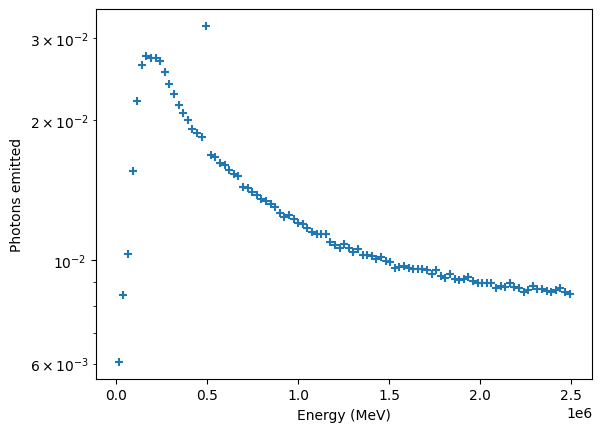

In [14]:
fig = plt.figure()

test_energy_bins = np.linspace(americium_energy_peaks_ev[0]-10000, cobalt_energy_peaks_ev[-1]+10000, num = 100)
plt.scatter(test_energy_bins[:-1], beam_results, marker = '+')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Photons emitted')
plt.show()

## Finding absolute efficiency

calculating absolute efficiency by finding the ratio of the peak heights to the number of photons emitted at the peak energy

In [15]:
efficiencies = []

def find_efficiency(calibration_results, peaks, calibration_energy_bins, peak_energies):
    calibration_results = np.array(calibration_results)
    peaks = np.array(peaks)

    efficiency_results = []
    peak_indices = [np.abs(calibration_energy_bins - peak).argmin() for peak in peak_energies]
    
    for i, idx in enumerate(peak_indices):
        photon_counts = calibration_results[idx]
        spectra_counts = peaks[i]
        efficiency_results.append(float(spectra_counts / (photon_counts))) #normalising denominator for photons emitted


    return efficiency_results

for i in range(len(labels)):
    efficiency = find_efficiency(decay_probabilities[i], current_list[i], np.array(decay_energies[i]), peaks_list[i])
    efficiencies.append(efficiency)


[0.0006819632523759236, 0.35908719155227053, 0.27677965714285696, 0.2988114500662252, 0.30530897168405363, 0.350192, 0.25566613003096, 0.26839270588235314, 0.23533040322580648, 0.28189495934959335, 0.266526604651163, 0.2971246451612905, 0.25249516404663414, 0.2455812807424595, 0.22238796782841835, 0.20980139449541294, 0.20669853750000017, 0.2102504485714287, 0.20297035999033575, 0.2165092759295499, 0.2073326666666667, 0.2681366417910447, 0.24448073684210533, 0.19355810940919047, 0.2079051297709924, 0.18819779220779237, 0.1740588726513569, 1.6167309278350521, 0.1713099063829789, 0.17306484185493462, 0.14790131113423502, 0.15762286567164188, 0.18555461052631575, 0.14978481818181816, 0.1590651293754819, 0.1425264227129338, 0.14860880603346693, 0.17447515695067267, 0.16731557142857148, 0.17343018181818196, 0.14281085714285713, 0.12852773662551448, 0.14106531310344833, 0.1323001984962407, 0.12833975241855872, 0.13622605317919084, 0.13746283870967735, 0.13020242774049223, 0.1301530254237289,

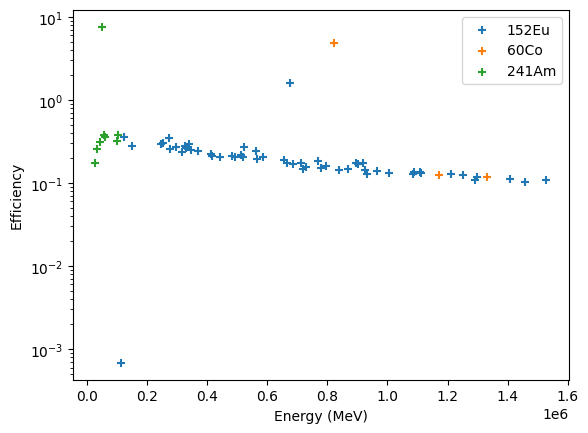

In [16]:
fig = plt.figure()

for i in range(len(labels)):
    plt.scatter(peaks_list[i], efficiencies[i], marker = '+', label = labels[i])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

## Finding intrinsic efficiency

finding intrinsic efficiency by comparing peak heights to number of photons found by detector in previous simulation

In [17]:
intrinsic_efficiencies = []

def find_intrinsic_efficiency(event_currents, peaks, event_energy_bins, peak_energies):
    event_currents = np.array(event_currents)
    peaks = np.array(peaks)

    efficiency_results = []

    peak_indices = [np.abs(event_energy_bins - peak).argmin() for peak in peak_energies]
    for i, idx in enumerate(peak_indices):
        photon_counts = event_currents[idx]
        spectra_counts = peaks[i]
        efficiency_results.append(float(spectra_counts / (photon_counts))) #normalising denominator for photons emitted


    return efficiency_results

for i in range(len(labels)):
    intrinsic_efficiency = find_efficiency(beam_results, current_list[i], test_energy_bins, peaks_list[i])
    intrinsic_efficiencies.append(intrinsic_efficiency)

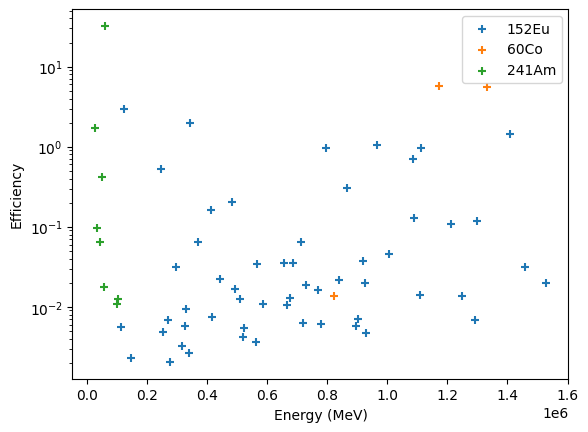

In [18]:
fig = plt.figure()

for i in range(len(labels)):
    plt.scatter(peaks_list[i], intrinsic_efficiencies[i], marker = '+', label = labels[i])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()